In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

In [7]:
#read in data
bikes = pd.read_csv('hour.csv')
bikes.head()

,index,date,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,demand
0,1,01-01-2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,01-01-2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,01-01-2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,01-01-2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,01-01-2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### 1. Remove columns that do not add any useful information

In [10]:
bikes_prep = bikes.copy()
bikes_prep = bikes_prep.drop(['index','date','casual','registered'],axis=1)
bikes_prep.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,demand
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


#### Basic analysis - check nulls

In [12]:
bikes_prep.isnull().sum()

season        0
year          0
month         0
hour          0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
demand        0
dtype: int64

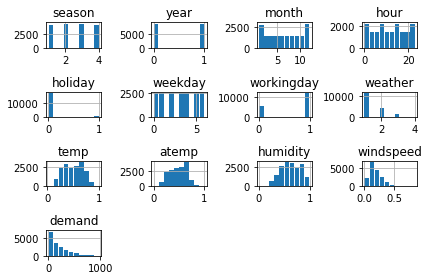

In [15]:
bikes_prep.hist(rwidth=0.9)
plt.tight_layout()
plt.show()

#### Continuous Variables data visualization

0 temp
1 atemp
2 humidity
3 windspeed


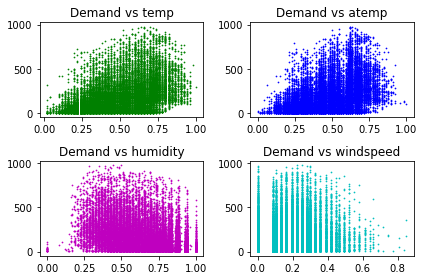

In [28]:
continuous_varibles = ['temp','atemp','humidity','windspeed']
colors = ['g','b','m','c']

#plot the various varibles
for i,var in enumerate(continuous_varibles):
    plt.subplot(2,2,i+1)
    plt.title(f"Demand vs {var}")
    plt.scatter(bikes_prep[var], bikes_prep.demand,s=0.5,c=colors[i])
    plt.tight_layout()

#### Categorical Varibles Visualization

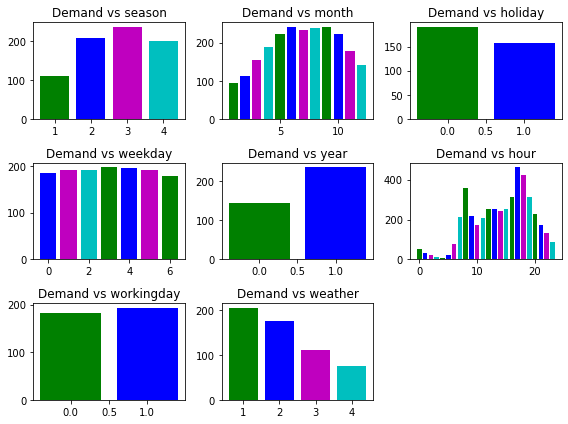

In [41]:
categorical_varibles = ['season','month','holiday','weekday','year','hour','workingday','weather']
colors = ['g','b','m','c']

plt.figure(figsize=(8, 6))
#plot the various varibles
for i,var in enumerate(categorical_varibles):
    plt.subplot(3,3,i+1)
    cat_list = bikes_prep[var].unique()
    cat_average = bikes_prep.groupby(var).mean()['demand']
    plt.title(f"Demand vs {var}")
    plt.bar(cat_list, cat_average,color=colors)
    plt.tight_layout()
    
#

### Data Notes 
- Demand is not normally distributed
- Demand varies with season, hieghst during fall and lowest in spring
- It also varies with month, with months in summer having the highest demand
- It is however not affected by day of the week, we should drop this column
- We have only 2 years so we can not drive much insight from this data, we will drop this feature as well
- Demand is highly depended on hour of the day with higher demand in morning hrs and evening at around 5pm
- Demand is not affected by working day or not 
- Temp and atemp seem to be corelated- we should check for autocorrelation
- More statisitical analysis needed for humidity and weather
- **There's high autocorrelation in the demand feature**

#### Dealing with multicolinearity

<AxesSubplot:>

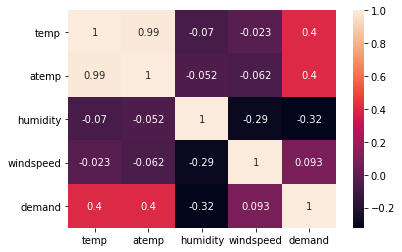

In [44]:
### get correlation matrix
correlation = bikes_prep[['temp','atemp','humidity','windspeed','demand']].corr()
sns.heatmap(correlation,annot=True) ## windspeed has zero correlation with demand, atemp has a perfect correlation with temp

In [47]:
### drop useless features based on analysis and correlation
bikes_prep.drop(['weekday','year','workingday','atemp','windspeed'],axis=1,inplace=True)

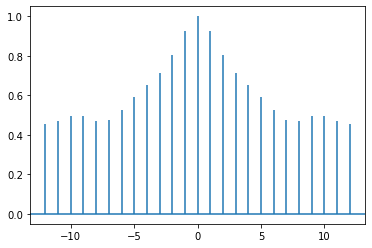

In [51]:
#check for autocorrelation using acorr
acorr_df = pd.to_numeric(bikes_prep['demand'],downcast='float')

plt.acorr(acorr_df,maxlags=12)
plt.show() #plot shows autocorrelation of 5 previous values

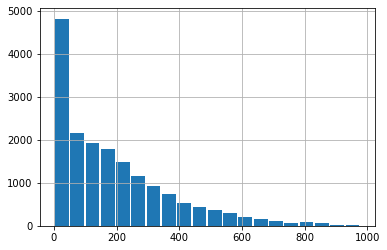

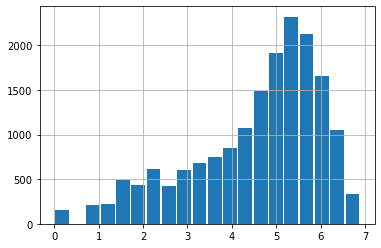

In [53]:
### Convert to log-normal distribution to make demand normally distributed
df1 = bikes_prep['demand']
df2 = np.log(df1)
plt.figure()
df1.hist(rwidth=0.9,bins=20)

plt.figure()
df2.hist(rwidth=0.9,bins=20)

bikes_prep['demand'] = np.log(bikes_prep['demand']) #make demand normally distributed

In [59]:
### fix autocorrelation
### create time lag features
t_1 = bikes_prep['demand'].shift(+1).to_frame()
t_1.columns = ['t-1']

t_2 = bikes_prep['demand'].shift(+2).to_frame()
t_2.columns = ['t-2']


t_3 = bikes_prep['demand'].shift(+3).to_frame()
t_3.columns = ['t-3']

bikes_prep_lag = pd.concat([bikes_prep,t_1,t_2,t_3],axis=1)
bikes_prep_lag.dropna(inplace=True)

#### Get dummy varibles

In [67]:
bikes_prep_lag = bikes_prep_lag.astype({'season':'category','hour':'category','holiday':'category','weather':'category','month':'category'})
bikes_prep_lag = pd.get_dummies(bikes_prep_lag,drop_first = True)

### Modelling

In [86]:
###data split for a time dependent data
Y = bikes_prep_lag[['demand']]
X = bikes_prep_lag.drop(['demand'],axis=1)

train_size = int(0.7*len(X))

X_train = X.values[0:train_size]
X_test = X.values[train_size:len(X)]

Y_train = Y.values[0:train_size]
Y_test = Y.values[train_size:len(Y)]

## Predicion
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train,Y_train)

r2_train = model.score(X_train,Y_train)
r2_test = model.score(X_test,Y_test)

Y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error,mean_squared_log_error
rmse = math.sqrt(mean_squared_error(Y_test,Y_pred))


##calculate RMSLE(Root Mean Squared Log Error)

Y_test_e = []
Y_predict_e = []

for i in range(0, len(Y_test)):
    Y_test_e.append(math.exp(Y_test[i]))
    Y_predict_e.append(math.exp(Y_pred[i]))

log_sq_sum = 0.0

for i in range(0, len(Y_test_e)):
    log_a = math.log(Y_test_e[i] + 1)
    log_p = math.log(Y_predict_e[i] + 1)
    log_diff = (log_p - log_a)**2
    log_sq_sum = log_sq_sum + log_diff

rmsle = math.sqrt(log_sq_sum/len(Y_test))


In [83]:
rmsle

0.11087545659246108